In [11]:
# Mount Google Drive (specific to Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import time

def start_timer():
    global start_time
    start_time = time.time()
    print(f"Timer started at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(start_time))}")

def stop_timer():
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Timer stopped at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(end_time))}")
    print(f"Elapsed time: {elapsed_time} seconds")


# **Import The Needed Library**


In [13]:
start_timer()

# Standard library imports
import os
import json
import random
import warnings
import itertools


# Data manipulation and scientific computing
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and neural network libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (BatchNormalization, Bidirectional, Conv1D,
                                     Dense, Dropout, LSTM, MaxPooling1D, Activation,
                                     AveragePooling1D, Concatenate, LayerNormalization,
                                     Add, Lambda, Flatten, Layer)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model evaluation metrics
from sklearn.metrics import (confusion_matrix, f1_score, recall_score,
                             precision_score, accuracy_score, classification_report)
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

# Filter out all warnings
warnings.filterwarnings("ignore")

# Disable TensorFlow warnings
tf.get_logger().setLevel('ERROR')


Timer started at 2024-06-03 20:51:58


# **Load the UCI-HAR Dataset**

In [14]:
root_train = '/content/drive/MyDrive/WithCV/UCI_HAR_Dataset/Train/train_Inertial_Signals'
root_test = '/content/drive/MyDrive/WithCV/UCI_HAR_Dataset/Testing/test_Inertial_Signals'
model_save_path = '/content/drive/MyDrive/WithCV/Hyperparameter-Tuning/UCI-CNN-ResLSTM-Attention.hdf5'

def file_name(file_dir):
    for root, dirs, files in os.walk(file_dir):
        return files

file_x_train =  ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt',
                'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
file_x_test = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt',
               'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
               'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

file_y_train = '/content/drive/MyDrive/WithCV/UCI_HAR_Dataset/Train/y_train.txt'
file_y_test = '/content/drive/MyDrive/WithCV/UCI_HAR_Dataset/Testing/y_test.txt'

def load_x(data, root):
    x_body_acc = []
    for file in data[0:3]:
        x_acc_input = np.array(pd.DataFrame(pd.read_csv(root + '/' + file, sep='\s+', header=None)))
        x_body_acc.append(x_acc_input)
    x_body_acc = np.transpose(np.array(x_body_acc), (1, 2, 0))

    x_gro = []
    for file in data[3:6]:
        x_gro_input = np.array(pd.DataFrame(pd.read_csv(root + '/' + file, sep='\s+', header=None)))
        x_gro.append(x_gro_input)
    x_gro = np.transpose(np.array(x_gro), (1, 2, 0))

    x_total_acc = []
    for file in data[6:9]:
        x_total_acc_input = np.array(pd.DataFrame(pd.read_csv(root + '/' + file, sep='\s+', header=None)))
        x_total_acc.append(x_total_acc_input)
    x_total_acc = np.transpose(np.array(x_total_acc), (1, 2, 0))
    return x_body_acc, x_gro, x_total_acc

def load_y(data):
    file = open(data, 'r')
    y_input = np.array([elem for elem in [row.strip().split(' ') for row in file]], dtype=np.int32)
    file.close()
    return to_categorical(y_input - 1.0)

x_body_acc_train, x_gro_train, x_total_acc_train = load_x(file_x_train, root_train)
x_body_acc_test, x_gro_test, x_total_acc_test = load_x(file_x_test, root_test)
y_train = load_y(file_y_train)
y_test = load_y(file_y_test)

# **Define the Attention Model**

In [15]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
        })
        return config

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

# **Define the Model Structure**



In [16]:

class CNNResLSTMAttentionModel:

    def __init__(self, learning_rate, batch_size):
        self.model = None
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def CNN_ResLSTM_Attention(self, input_forward, input_backward):
        # 1D-CNN layers with different kernels
        conv1_forward = Conv1D(128, 3, activation='relu', padding='same')(input_forward)
        conv1_backward = Conv1D(128, 3, activation='relu', padding='same')(input_backward)

        # Concatenate CNN outputs
        concatenated = Concatenate()([conv1_forward, conv1_backward])

        # Batch Normalization
        model = BatchNormalization()(concatenated)

        # Max Pooling
        model = MaxPooling1D(pool_size=2)(model)

        # Dropout
        model = Dropout(0.2)(model)

        # 1D-CNN layers with different kernels
        model = Conv1D(128, 3, activation='relu', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        # 1D-CNN layers with different kernels
        model = Conv1D(64, 3, activation='relu', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        # 1D-CNN layers with different kernels
        model = Conv1D(32, 3, activation='relu', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        # Layer Normalization
        model = LayerNormalization()(model)

        # LSTM layers
        x = LSTM(64, return_sequences=True)(model)
        model = LayerNormalization()(x)
        y = LSTM(64, return_sequences=True)(model)
        model = Add()([x, y])

        # Attention layer
        output = Attention(8)(model)

        return output

    def create_model(self, learning_rate, batch_size):
        # Define the input layers
        input_1_forward = Input(shape=(128, 3))
        input_1_backward = Input(shape=(128, 3))
        input_2_forward = Input(shape=(128, 3))
        input_2_backward = Input(shape=(128, 3))
        input_3_forward = Input(shape=(128, 3))
        input_3_backward = Input(shape=(128, 3))

        # Flip the second input data
        input_1_backward_flipped = Lambda(lambda x: K.reverse(x, axes=1))(input_1_backward)
        input_2_backward_flipped = Lambda(lambda x: K.reverse(x, axes=1))(input_2_backward)
        input_3_backward_flipped = Lambda(lambda x: K.reverse(x, axes=1))(input_3_backward)

        # Now, we pass both forward and backward inputs to the CNN_ResLSTM_Attention method
        model1 = self.CNN_ResLSTM_Attention(input_1_forward, input_1_backward_flipped)
        model2 = self.CNN_ResLSTM_Attention(input_2_forward, input_2_backward_flipped)
        model3 = self.CNN_ResLSTM_Attention(input_3_forward, input_3_backward_flipped)

        concatenated_models = Concatenate()([model1, model2, model3])

        output = Dropout(0.2)(concatenated_models)
        output = Dense(6)(output)
        output = Activation('softmax', name="softmax")(output)
        self.model = Model(inputs=[input_1_forward, input_1_backward, input_2_forward, input_2_backward, input_3_forward, input_3_backward], outputs=output)
        self.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),metrics=['accuracy'])

    def fit(self, X, y, learning_rate, batch_size, epochs, validation_data, early_stopping):

        self.create_model(learning_rate, batch_size)

        # Callbacks
        callbacks = []

        if early_stopping:
          callbacks.append(EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True))

        callbacks.append(ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1))

        # Training the model with validation
        history = self.model.fit(
            X, y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=validation_data,
            callbacks=callbacks)

        return history

    def fit2(self, X, y, learning_rate, batch_size, epochs, validation_data):
        self.create_model(learning_rate, batch_size)

        # Callbacks
        callbacks = []
        callbacks.append(EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True))
        callbacks.append(ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1))

        # Training the model with validation
        history = self.model.fit(
             X, y,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=validation_data,
             callbacks=callbacks
         )
        return history

    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size
        }


    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


# **Use 5-Fold GridSearchCV to test different combinations of the parameters**

In [ ]:
param_grid = {
    'learning_rate': [ 0.01 , 0.001, 0.0001],
    'batch_size': [32 , 64]
}
param_combinations = [(lr, bs) for lr in param_grid['learning_rate'] for bs in param_grid['batch_size']]

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

best_loss = float('inf')
best_params_list = []

# Initialize the best accuracy variable and list for storing the best parameters
best_accuracy = 0

for lr, bs in param_combinations:
    print(f"_________________________________________________________________________\nTesting Parameters: Learning Rate: {lr}, Batch Size: {bs}")

    fold_losses = []

    # Perform cross-validation
    for split, (train_index, val_index) in enumerate(kf.split(x_body_acc_train), 1):
        print(f"____________________________________________________\nSplit {split}\n____________________________________________________")

        # Create an instance of CNNResLSTMAttentionModel with the specified hyperparameters
        model = CNNResLSTMAttentionModel(learning_rate=lr, batch_size=bs)

        # Split data into training and validation sets for each sensor type
        x_body_acc_train_fold = x_body_acc_train[train_index]
        x_body_acc_val_fold = x_body_acc_train[val_index]

        x_gro_train_fold = x_gro_train[train_index]
        x_gro_val_fold = x_gro_train[val_index]

        x_total_acc_train_fold = x_total_acc_train[train_index]
        x_total_acc_val_fold = x_total_acc_train[val_index]

        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        validation_data = (
        [x_body_acc_val_fold, np.flip(x_body_acc_val_fold, axis=1),
         x_gro_val_fold, np.flip(x_gro_val_fold, axis=1),
         x_total_acc_val_fold, np.flip(x_total_acc_val_fold, axis=1)],
         y_val_fold)


        # Fit the model to the training data for this fold with validation data
        history = model.fit(
         [x_body_acc_train_fold, np.flip(x_body_acc_train_fold, axis=1),
         x_gro_train_fold, np.flip(x_gro_train_fold, axis=1),
         x_total_acc_train_fold, np.flip(x_total_acc_train_fold, axis=1)],
         y_train_fold, learning_rate=lr, batch_size=bs, epochs=75, validation_data=validation_data, early_stopping=True)

        # Evaluate the model on the validation data directly
        val_loss, val_accuracy = model.model.evaluate(
            [x_body_acc_val_fold, np.flip(x_body_acc_val_fold, axis=1),
             x_gro_val_fold, np.flip(x_gro_val_fold, axis=1),
             x_total_acc_val_fold, np.flip(x_total_acc_val_fold, axis=1)],
            y_val_fold, verbose=0
        )

        fold_losses.append(val_loss)


        print(f"\n\nValidation Loss for Split {split}: {val_loss:.4f}")

    mean_loss = np.mean(fold_losses)
    print(f"Mean Loss for Parameters: {lr}, {bs} is {mean_loss:.4f}")

    if mean_loss < best_loss:
        best_loss = mean_loss
        best_params_list = [(lr, bs)]
        print(f"New best parameters found: {lr}, {bs}")

print(f"\nBest Overall Parameters: {best_params_list}, with a loss of {best_loss:.4f}")

Streaming output truncated to the last 5000 lines.
Epoch 3/75
183/184 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9332
Epoch 3: val_loss improved from 0.19662 to 0.14672, saving model to /content/drive/MyDrive/WithCV/Hyperparameter-Tuning/UCI-CNN-ResLSTM-Attention.hdf5
184/184 [==============================] - 7s 40ms/step - loss: 0.1717 - accuracy: 0.9334 - val_loss: 0.1467 - val_accuracy: 0.9435
Epoch 4/75
183/184 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9471
Epoch 4: val_loss improved from 0.14672 to 0.13983, saving model to /content/drive/MyDrive/WithCV/Hyperparameter-Tuning/UCI-CNN-ResLSTM-Attention.hdf5
184/184 [==============================] - 8s 41ms/step - loss: 0.1431 - accuracy: 0.9471 - val_loss: 0.1398 - val_accuracy: 0.9381
Epoch 5/75
183/184 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9488
Epoch 5: val_loss improved from 0.13983 to 0.10582, saving model to /content/drive/MyDrive/With

# **Now we train and test with the "test" section of the database that we set aside:**

Epoch 1/150
183/184 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.9049
Epoch 1: val_accuracy improved from -inf to 0.19103, saving model to /content/drive/MyDrive/WithCV/Hyperparameter-Tuning/UCI-CNN-ResLSTM-Attention.hdf5
184/184 [==============================] - 37s 53ms/step - loss: 0.2844 - accuracy: 0.9049 - val_loss: 3.3181 - val_accuracy: 0.1910
Epoch 2/150
183/184 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9419
Epoch 2: val_accuracy improved from 0.19103 to 0.57308, saving model to /content/drive/MyDrive/WithCV/Hyperparameter-Tuning/UCI-CNN-ResLSTM-Attention.hdf5
184/184 [==============================] - 6s 34ms/step - loss: 0.1446 - accuracy: 0.9422 - val_loss: 1.5773 - val_accuracy: 0.5731
Epoch 3/150
184/184 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9488
Epoch 3: val_accuracy improved from 0.57308 to 0.91230, saving model to /content/drive/MyDrive/WithCV/Hyperparameter-Tuning/UCI-CNN-ResLS

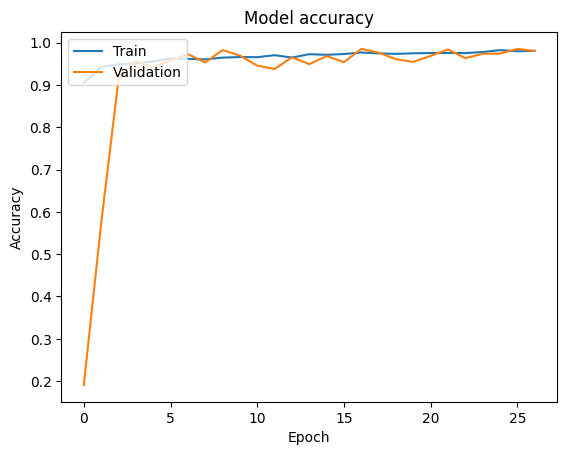

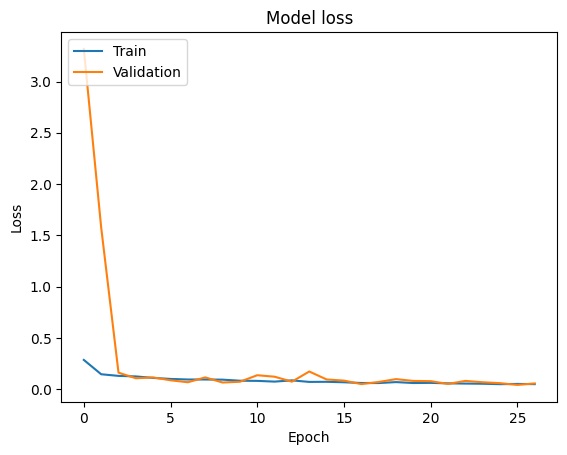

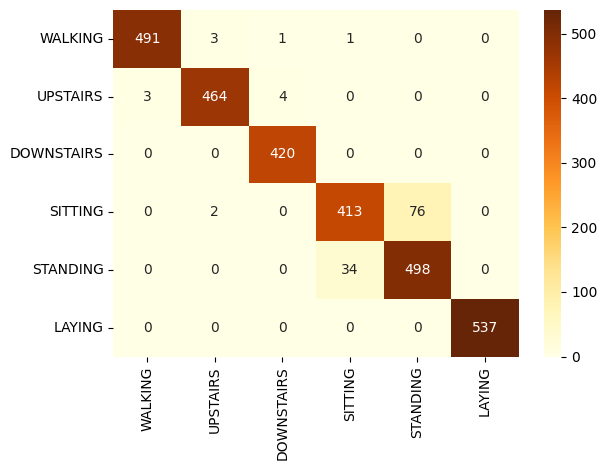

Metrics for WALKING:
  True Positives (TP): 491
  True Negatives (TN): 2448
  False Positives (FP): 3
  False Negatives (FN): 5

Metrics for UPSTAIRS:
  True Positives (TP): 464
  True Negatives (TN): 2471
  False Positives (FP): 5
  False Negatives (FN): 7

Metrics for DOWNSTAIRS:
  True Positives (TP): 420
  True Negatives (TN): 2522
  False Positives (FP): 5
  False Negatives (FN): 0

Metrics for SITTING:
  True Positives (TP): 413
  True Negatives (TN): 2421
  False Positives (FP): 35
  False Negatives (FN): 78

Metrics for STANDING:
  True Positives (TP): 498
  True Negatives (TN): 2339
  False Positives (FP): 76
  False Negatives (FN): 34

Metrics for LAYING:
  True Positives (TP): 537
  True Negatives (TN): 2410
  False Positives (FP): 0
  False Negatives (FN): 0

Timer stopped at 2024-06-03 20:56:53
Elapsed time: 295.0645263195038 seconds


In [18]:
best_params = {
    'learning_rate': 0.001,
    'batch_size': 32
}

# Reserve a portion of the training data for validation
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    np.concatenate([x_body_acc_train, x_gro_train, x_total_acc_train], axis=-1),
    y_train,
    test_size=0.2,
    random_state=42
)


# Train the final model using the best hyperparameters
best_model = CNNResLSTMAttentionModel(learning_rate=best_params['learning_rate'],
                               batch_size=best_params['batch_size'])


# Fit the model to the training data with validation data
history = best_model.fit2(
    X=[
        x_train_final[:, :, :3],  # Original body acceleration data for the final model
        np.flip(x_train_final[:, :, :3], axis=1),  # Flipped body acceleration data for the final model
        x_train_final[:, :, 3:6],  # Original body gyro data for the final model
        np.flip(x_train_final[:, :, 3:6], axis=1),  # Flipped body gyro data for the final model
        x_train_final[:, :, 6:],  # Original total acceleration data for the final model
        np.flip(x_train_final[:, :, 6:], axis=1)  # Flipped total acceleration data for the final model
    ],
    y=y_train_final,
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    epochs=150,
    validation_data=(
        [
            x_val_final[:, :, :3],  # Original validation body acceleration data
            np.flip(x_val_final[:, :, :3], axis=1),  # Flipped validation body acceleration data
            x_val_final[:, :, 3:6],  # Original validation body gyro data
            np.flip(x_val_final[:, :, 3:6], axis=1),  # Flipped validation body gyro data
            x_val_final[:, :, 6:],  # Original validation total acceleration data
            np.flip(x_val_final[:, :, 6:], axis=1)  # Flipped validation total acceleration data
        ],
        y_val_final
    )
)


# Evaluate the model on the test data
test_loss, test_accuracy = best_model.model.evaluate([x_body_acc_test, np.flip(x_body_acc_test, axis=1),
                                                      x_gro_test, np.flip(x_gro_test, axis=1),
                                                      x_total_acc_test, np.flip(x_total_acc_test, axis=1)],
                                                     y_test, verbose=0)

# Calculate additional evaluation metrics
y_pred = best_model.model.predict([x_body_acc_test, np.flip(x_body_acc_test, axis=1),
                                   x_gro_test, np.flip(x_gro_test, axis=1),
                                   x_total_acc_test, np.flip(x_total_acc_test, axis=1)])

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate various precision, recall, and F1 scores
precision_macro = precision_score(y_true_labels, y_pred_labels, average='macro')
precision_weighted = precision_score(y_true_labels, y_pred_labels, average='weighted')
precision_micro = precision_score(y_true_labels, y_pred_labels, average='micro')

recall_macro = recall_score(y_true_labels, y_pred_labels, average='macro')
recall_weighted = recall_score(y_true_labels, y_pred_labels, average='weighted')
recall_micro = recall_score(y_true_labels, y_pred_labels, average='micro')

f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
f1_weighted = f1_score(y_true_labels, y_pred_labels, average='weighted')
f1_micro = f1_score(y_true_labels, y_pred_labels, average='micro')

accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate macro accuracy
macro_accuracy = per_class_accuracy.mean()

# Calculate weighted accuracy
weighted_accuracy = np.average(per_class_accuracy, weights=np.bincount(y_true_labels))

population_std_dev_true = np.std(y_true_labels, ddof=0)
population_std_dev_pred = np.std(y_pred_labels, ddof=0)

sample_std_dev_true = np.std(y_true_labels, ddof=1)
sample_std_dev_pred = np.std(y_pred_labels, ddof=1)


# Print model summary
best_model.model.summary()
total_params = best_model.model.count_params()
print("Total parameters:", total_params)

# Print evaluation metrics
# Calculate the average accuracy over all epochs
average_accuracy = np.mean(history.history['accuracy'])
# Best accuracy over all epochs
best_accuracy = np.max(history.history['accuracy'])
# Accuracy of the last epoch
last_accuracy = history.history['accuracy'][-1]

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Best Accuracy: {best_accuracy}")
print(f"Average Accuracy over all epochs: {average_accuracy:.4f}")
print(f"Last Epoch Accuracy: {last_accuracy}")

print(f"Micro Accuracy: {accuracy:.4f}")
print(f"Macro Accuracy: {macro_accuracy:.4f}")
print(f"Weighted Accuracy: {weighted_accuracy:.4f}")

print("Precision (Macro):", precision_macro)
print("Precision (Weighted):", precision_weighted)
print("Precision (Micro):", precision_micro)

print("Recall (Macro):", recall_macro)
print("Recall (Weighted):", recall_weighted)
print("Recall (Micro):", recall_micro)

print("F1 Score (Macro):", f1_macro)
print("F1 Score (Weighted):", f1_weighted)
print("F1 Score (Micro):", f1_micro)

print("Population Std Dev - True Labels:", population_std_dev_true)
print("Population Std Dev - Predicted Labels:", population_std_dev_pred)
print("Sample Std Dev - True Labels:", sample_std_dev_true)
print("Sample Std Dev - Predicted Labels:", sample_std_dev_pred)
print("_______________________________________________________________\n")


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate y_true and y_pred_classes
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
cm = pd.DataFrame(conf_matrix, columns=['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
                  index=['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
sns.heatmap(cm, cmap="YlOrBr", fmt="d", annot=True)
plt.tight_layout()
plt.show()

# Calculate TP, TN, FP, FN for each class
def calculate_confusion_metrics(conf_matrix):
    TP = np.diag(conf_matrix)  # True Positives are on the diagonal
    FP = np.sum(conf_matrix, axis=0) - TP  # False Positives are column sums minus TP
    FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives are row sums minus TP
    TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives are total sum minus FP, FN, TP

    return TP, TN, FP, FN

# Assuming 'conf_matrix' is your confusion matrix from your model's predictions
TP, TN, FP, FN = calculate_confusion_metrics(conf_matrix)

# Print results for each class
classes = ['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
for i, class_label in enumerate(classes):
    print(f"Metrics for {class_label}:")
    print(f"  True Positives (TP): {TP[i]}")
    print(f"  True Negatives (TN): {TN[i]}")
    print(f"  False Positives (FP): {FP[i]}")
    print(f"  False Negatives (FN): {FN[i]}\n")

stop_timer()